In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import count, when, col
from pyspark.ml.feature import VectorAssembler, MinMaxScaler


In [2]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

In [10]:
# Build the SparkSession
spark = SparkSession.builder \
   .master("local") \
   .appName("DDAM Project") \
   .config("spark.executor.memory", "1gb") \
   .getOrCreate()
   
sc = spark.sparkContext

# import

In [11]:
df_clustering = spark.read.csv("df_clustering.csv", header=True, inferSchema=True)

In [14]:
df_clustering.show()

+---+---+---+---+---+---+---+---+---+---+---+---+---+----------+
| 3P|3PA| FT|FTA|ORB|DRB|AST|STL|BLK|TOV| PF|PTS|+/-|MP_seconds|
+---+---+---+---+---+---+---+---+---+---+---+---+---+----------+
|  2|  9|  5|  7|  4| 10| 10|  1|  0|  6|  4| 27| -6|      2880|
|  0|  0|  5|  6|  2|  5|  1|  1|  4|  3|  3| 19|  0|      2248|
|  0|  0|  0|  0|  2| 10|  2|  0|  2|  3|  4|  2|-15|      2196|
|  2|  5|  3|  4|  1|  4|  1|  1|  0|  3|  5| 11| -4|      2072|
|  0|  3|  1|  2|  3|  2|  2|  0|  1|  1|  5|  7|-15|      1021|
|  4|  6|  2|  3|  0|  4|  3|  1|  0|  1|  2| 18| 14|      1878|
|  0|  0|  0|  0|  1|  1|  0|  1|  1|  2|  1|  4| -2|      1121|
|  0|  0|  0|  0|  1|  1|  0|  0|  1|  0|  1|  0| -2|       707|
|  0|  0|  0|  0|  0|  1|  1|  0|  0|  0|  0|  0|  0|       277|
|  0|  1|  3|  6|  1|  6|  7|  3|  1|  6|  3| 27|  3|      2526|
|  0|  2|  1|  3|  0| 10|  9|  3|  0|  0|  2| 15|  6|      2433|
|  2|  8|  5|  9|  2|  3|  3|  3|  2|  2|  5| 25|  8|      2330|
|  0|  0|  2|  6|  1| 11|

# Scaler

In [11]:
# grid con cluster da 2 a 10, con diverse tipi di distanze

In [12]:
# Definire le colonne da utilizzare per il clustering
col = ["3P", "3PA", "FT", "FTA", "ORB", "DRB", "AST", "STL", "BLK", "TOV", "PF", "PTS", "+/-", "MP_seconds"]

# Creare un VectorAssembler
assembler = VectorAssembler(inputCols=col, outputCol="features")

# Applicare l'assemblatore
output_dataset = assembler.transform(df_clustering)

# Creare uno scaler per normalizzare le features
scaler = MinMaxScaler(inputCol="features", outputCol="features_scaled")

# Applicare lo scaler
output_dataset = scaler.fit(output_dataset).transform(output_dataset)

# Modello

K=2, SSE=44979.630147750795
K=3, SSE=38111.783088663775
K=4, SSE=34692.40566640432
K=5, SSE=32416.63554090236
K=6, SSE=30675.11930441383
K=7, SSE=29368.835831501776
K=8, SSE=28383.043089124385
K=9, SSE=27342.2767951184
K=10, SSE=26568.862496261532


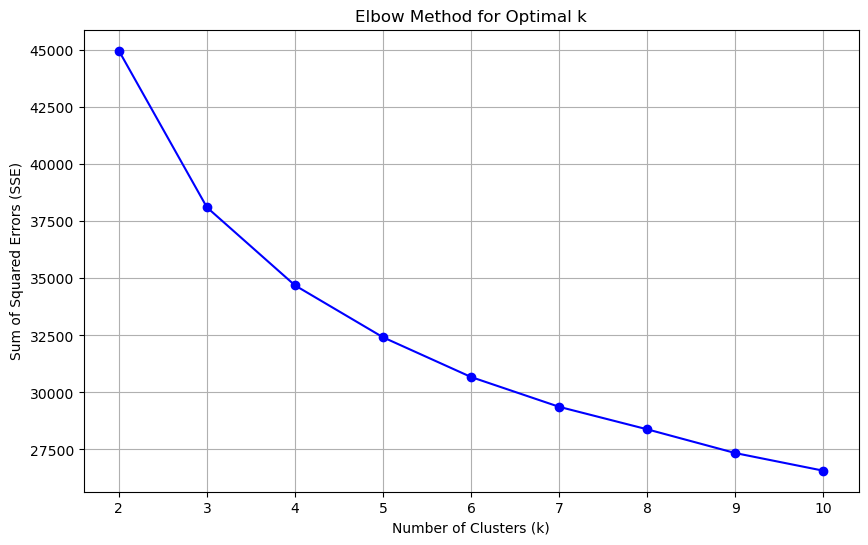

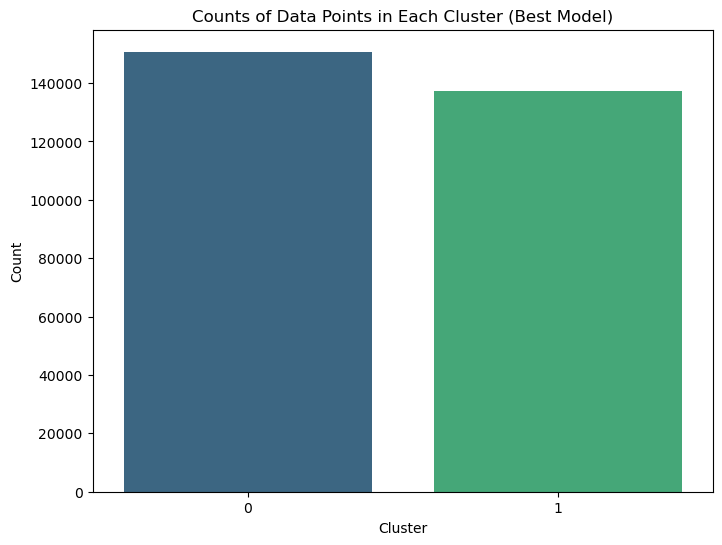

In [14]:
# Creare una lista per registrare i valori di SSE
sse_list = []

# Calcolo SSE utilizzando distanza ottimale trovata dalla grid 
for k_value in range(2, 11):
    kmeans = KMeans(featuresCol="features_scaled", k=k_value, distanceMeasure=optimal_distance)
    model = kmeans.fit(output_dataset)
    predictions = model.transform(output_dataset)

    # Calcolo SSE
    sse = model.summary.trainingCost # K-means cost (sum of squared distances to the nearest centroid for all points in the training dataset).
    
    sse_list.append((k_value, sse))

# Stampa i valori di SSE per ogni valore di k
for k, sse in sse_list:
    print(f"K={k}, SSE={sse}")

# Estrai i valori di k e SSE per il plot
k_values, sse_values = zip(*sse_list)

# Crea un line plot
plt.figure(figsize=(10, 6))
plt.plot(k_values, sse_values, marker='o', linestyle='-', color='b')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Sum of Squared Errors (SSE)')
plt.grid(True)
plt.show()

# Clustering con miglior modello trvoato dalla grid
bestModel_predictions = bestModel.transform(output_dataset)

# Convertire i risultati in un DataFrame Pandas
pandas_df = bestModel_predictions.select("prediction").toPandas()

# Contare le occorrenze di ciascun cluster
cluster_counts = pandas_df["prediction"].value_counts().sort_index()

plt.figure(figsize=(8, 6))
sns.barplot(x=cluster_counts.index, y=cluster_counts.values, palette="viridis")
plt.title("Counts of Data Points in Each Cluster (Best Model)")
plt.xlabel("Cluster")
plt.ylabel("Count")
plt.show()

K=2, Silhouette=0.4946931967753324
K=3, Silhouette=0.2357516290815615
K=4, Silhouette=0.0836541781297452
K=5, Silhouette=0.06234008901188662
K=6, Silhouette=0.014343258804345047
K=7, Silhouette=-0.0014690328151191108
K=8, Silhouette=-0.031161871575073375
K=9, Silhouette=-0.08545190953218852
K=10, Silhouette=-0.10680394495787685


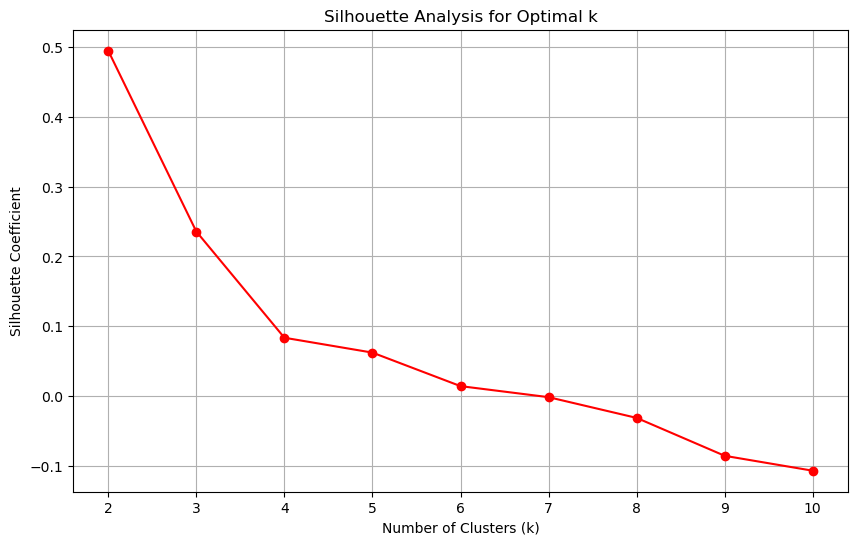

In [15]:

silhouette_list = []

# Qua, come per l'SSE, prendo la distanza ottimale trovata dalla grid
for k_value in range(2, 11):
    kmeans = KMeans(featuresCol="features_scaled", k=k_value, distanceMeasure=optimal_distance)
    model = kmeans.fit(output_dataset)
    predictions = model.transform(output_dataset)

    # Calcolare Silhouette
    evaluator = ClusteringEvaluator()
    silhouette = evaluator.evaluate(predictions)
    
    silhouette_list.append((k_value, silhouette))

for k, silhouette in silhouette_list:
    print(f"K={k}, Silhouette={silhouette}")

k_values_silhouette, silhouette_values = zip(*silhouette_list)

plt.figure(figsize=(10, 6))
plt.plot(k_values_silhouette, silhouette_values, marker='o', linestyle='-', color='r')
plt.title('Silhouette Analysis for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Coefficient')
plt.grid(True)
plt.show()


In [16]:
# Chiudere la sessione Spark
spark.stop()